# Starbucks Capstone Challenge

### Introduction

This data set contains simulated data that mimics customer behavior on the Starbucks rewards mobile app. Once every few days, Starbucks sends out an offer to users of the mobile app. An offer can be merely an advertisement for a drink or an actual offer such as a discount or BOGO (buy one get one free). Some users might not receive any offer during certain weeks. 

Not all users receive the same offer, and that is the challenge to solve with this data set.

Your task is to combine transaction, demographic and offer data to determine which demographic groups respond best to which offer type. This data set is a simplified version of the real Starbucks app because the underlying simulator only has one product whereas Starbucks actually sells dozens of products.

Every offer has a validity period before the offer expires. As an example, a BOGO offer might be valid for only 5 days. You'll see in the data set that informational offers have a validity period even though these ads are merely providing information about a product; for example, if an informational offer has 7 days of validity, you can assume the customer is feeling the influence of the offer for 7 days after receiving the advertisement.

You'll be given transactional data showing user purchases made on the app including the timestamp of purchase and the amount of money spent on a purchase. This transactional data also has a record for each offer that a user receives as well as a record for when a user actually views the offer. There are also records for when a user completes an offer. 

Keep in mind as well that someone using the app might make a purchase through the app without having received an offer or seen an offer.

### Example

To give an example, a user could receive a discount offer buy 10 dollars get 2 off on Monday. The offer is valid for 10 days from receipt. If the customer accumulates at least 10 dollars in purchases during the validity period, the customer completes the offer.

However, there are a few things to watch out for in this data set. Customers do not opt into the offers that they receive; in other words, a user can receive an offer, never actually view the offer, and still complete the offer. For example, a user might receive the "buy 10 dollars get 2 dollars off offer", but the user never opens the offer during the 10 day validity period. The customer spends 15 dollars during those ten days. There will be an offer completion record in the data set; however, the customer was not influenced by the offer because the customer never viewed the offer.

### Cleaning

This makes data cleaning especially important and tricky.

You'll also want to take into account that some demographic groups will make purchases even if they don't receive an offer. From a business perspective, if a customer is going to make a 10 dollar purchase without an offer anyway, you wouldn't want to send a buy 10 dollars get 2 dollars off offer. You'll want to try to assess what a certain demographic group will buy when not receiving any offers.

### Final Advice

Because this is a capstone project, you are free to analyze the data any way you see fit. For example, you could build a machine learning model that predicts how much someone will spend based on demographics and offer type. Or you could build a model that predicts whether or not someone will respond to an offer. Or, you don't need to build a machine learning model at all. You could develop a set of heuristics that determine what offer you should send to each customer (i.e., 75 percent of women customers who were 35 years old responded to offer A vs 40 percent from the same demographic to offer B, so send offer A).

# Data Sets

The data is contained in three files:

* portfolio.json - containing offer ids and meta data about each offer (duration, type, etc.)
* profile.json - demographic data for each customer
* transcript.json - records for transactions, offers received, offers viewed, and offers completed

Here is the schema and explanation of each variable in the files:

**portfolio.json**
* id (string) - offer id
* offer_type (string) - type of offer ie BOGO, discount, informational
* difficulty (int) - minimum required spend to complete an offer
* reward (int) - reward given for completing an offer
* duration (int) - time for offer to be open, in days
* channels (list of strings)

**profile.json**
* age (int) - age of the customer 
* became_member_on (int) - date when customer created an app account
* gender (str) - gender of the customer (note some entries contain 'O' for other rather than M or F)
* id (str) - customer id
* income (float) - customer's income

**transcript.json**
* event (str) - record description (ie transaction, offer received, offer viewed, etc.)
* person (str) - customer id
* time (int) - time in hours since start of test. The data begins at time t=0
* value - (dict of strings) - either an offer id or transaction amount depending on the record

**Note:** If you are using the workspace, you will need to go to the terminal and run the command `conda update pandas` before reading in the files. This is because the version of pandas in the workspace cannot read in the transcript.json file correctly, but the newest version of pandas can. You can access the termnal from the orange icon in the top left of this notebook.  

You can see how to access the terminal and how the install works using the two images below.  First you need to access the terminal:

<img src="pic1.png"/>

Then you will want to run the above command:

<img src="pic2.png"/>

Finally, when you enter back into the notebook (use the jupyter icon again), you should be able to run the below cell without any errors.

In [102]:
import pandas as pd
import numpy as np
import math
import json
from datetime import datetime
from time import time
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import accuracy_score,f1_score
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
# read in the json files
portfolio = pd.read_json('data/portfolio.json', orient='records', lines=True)
profile = pd.read_json('data/profile.json', orient='records', lines=True)
transcript = pd.read_json('data/transcript.json', orient='records', lines=True)

% matplotlib inline

In [103]:
portfolio

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5
5,"[web, email, mobile, social]",7,7,2298d6c36e964ae4a3e7e9706d1fb8c2,discount,3
6,"[web, email, mobile, social]",10,10,fafdcd668e3743c1bb461111dcafc2a4,discount,2
7,"[email, mobile, social]",0,3,5a8bc65990b245e5a138643cd4eb9837,informational,0
8,"[web, email, mobile, social]",5,5,f19421c1d4aa40978ebb69ca19b0e20d,bogo,5
9,"[web, email, mobile]",10,7,2906b810c7d4411798c6938adc9daaa5,discount,2


In [104]:
portfolio.head()

,channels,difficulty,duration,id,offer_type,reward
0,"[email, mobile, social]",10,7,ae264e3637204a6fb9bb56bc8210ddfd,bogo,10
1,"[web, email, mobile, social]",10,5,4d5c57ea9a6940dd891ad53e9dbe8da0,bogo,10
2,"[web, email, mobile]",0,4,3f207df678b143eea3cee63160fa8bed,informational,0
3,"[web, email, mobile]",5,7,9b98b8c7a33c4b65b9aebfe6a799e6d9,bogo,5
4,"[web, email]",20,10,0b1e1539f2cc45b7b9fa7c272da2e1d7,discount,5


In [105]:
# Checking NaNs
profile.isna().sum(axis=0)

age                    0
became_member_on       0
gender              2175
id                     0
income              2175
dtype: int64

In [106]:
profile.shape

(17000, 5)

In [107]:
# Checking null value
profile[profile['income'].isnull()].count()

age                 2175
became_member_on    2175
gender                 0
id                  2175
income                 0
dtype: int64

### Data Cleaning

In [108]:
# Converting to datetime
profile.became_member_on = pd.to_datetime(profile.became_member_on, format = '%Y%m%d')

In [109]:
# Remove outliers (age 118)
remove = profile[profile.age == 118]
profile = profile[profile.age < 118].reset_index(drop=True)

In [110]:
# store 0 and 1s in new columns
profile['missing'] = profile['age'].apply(lambda val: 1 if pd.isna(val) else 0)
dropped = profile[profile['missing'] == 1].index
# cleaned Dataset
clean_profile = profile.drop(dropped)

In [111]:
clean_profile.head()

,age,became_member_on,gender,id,income,missing
0,55,2017-07-15,F,0610b486422d4921ae7d2bf64640c50b,112000.0,0
1,75,2017-05-09,F,78afa995795e4d85b5d9ceeca43f5fef,100000.0,0
2,68,2018-04-26,M,e2127556f4f64592b11af22de27a7932,70000.0,0
3,65,2018-02-09,M,389bc3fa690240e798340f5a15918d5c,53000.0,0
4,58,2017-11-11,M,2eeac8d8feae4a8cad5a6af0499a211d,51000.0,0


In [112]:
dataf1 = transcript[transcript.event == 'transaction']
dataf2 = transcript[transcript.event == 'offer received']
dataf3 = transcript[transcript.event == 'offer viewed']
dataf4 = transcript[transcript.event == 'offer completed']
dataf1['amount'] = dataf1.value.apply(lambda x:list(x.values())[0])
dataf2['offer_id'] = dataf2.value.apply(lambda x:list(x.values())[0])
dataf3['offer_id'] = dataf3.value.apply(lambda x:list(x.values())[0])
dataf4['offer_id'] = dataf4.value.apply(lambda x:list(x.values())[0])
dataf4['reward'] = dataf4.value.apply(lambda x:list(x.values())[1])

In [113]:
transcript = pd.concat([dataf1,dataf2,dataf3,dataf4])
transcript = transcript[['event' , 'person' , 'offer_id' ,'time', 'amount' , 'reward' , 'value']]
transcript.drop(columns='value' , inplace=True)

In [114]:
transcript.head()

,event,person,offer_id,time,amount,reward
12654,transaction,02c083884c7d45b39cc68e1314fec56c,NaN,0,0.83,NaN
12657,transaction,9fa9ae8f57894cc9a3b8a9bbe0fc1b2f,NaN,0,34.56,NaN
12659,transaction,54890f68699049c2a04d415abc25e717,NaN,0,13.23,NaN
12670,transaction,b2f1cd155b864803ad8334cdf13c4bd2,NaN,0,19.51,NaN
12671,transaction,fe97aa22dd3e48c8b143116a8403dd52,NaN,0,18.97,NaN


### Data Analysis

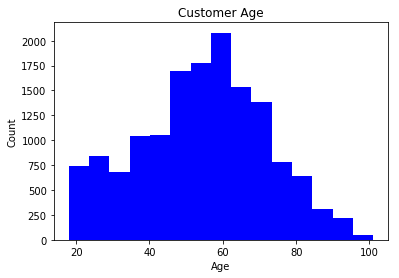

In [115]:
plt.hist(clean_profile['age'], bins = 15, color = 'blue');
plt.xlabel('Age');
plt.ylabel('Count');
plt.title('Customer Age');

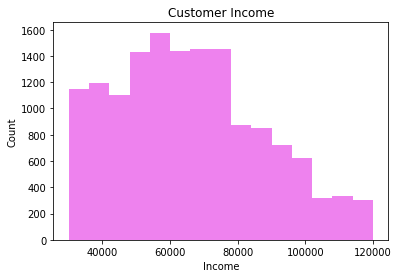

In [116]:
plt.hist(clean_profile['income'], bins = 15, color = 'violet');
plt.xlabel('Income');
plt.ylabel('Count');
plt.title('Customer Income');

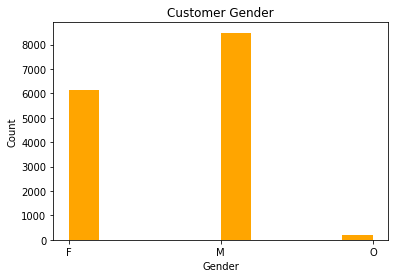

In [117]:
plt.hist(clean_profile['gender'], bins = 10, color = 'orange');
plt.xlabel('Gender');
plt.ylabel('Count');
plt.title('Customer Gender');

In [118]:
clean_profile['membership_year'] = profile['became_member_on'].dt.year

In [119]:
clean_profile['membership_year'].count()

14825

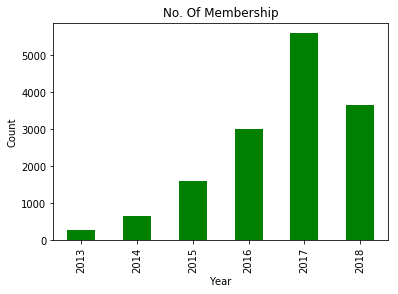

In [120]:
mem_plot = clean_profile.groupby('membership_year').count()['id']
mem_plot.plot(kind = 'bar', color = 'green')
plt.title('No. Of Membership')
plt.xlabel('Year')
plt.ylabel('Count')
plt.show()

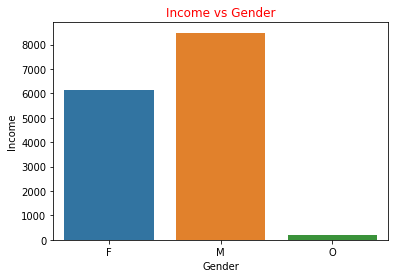

In [121]:
sns.countplot(x=clean_profile[clean_profile['gender'] != 'NA']['gender'])
plt.title('Income vs Gender',color='red')
plt.ylabel('Income')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.show();

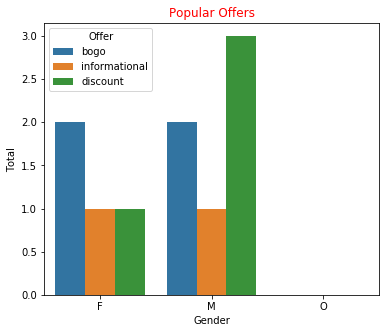

In [122]:
plt.figure(figsize=(6, 5))
sns.countplot(x=clean_profile.gender, hue=portfolio.offer_type)
plt.title('Popular Offers',color='red')
plt.ylabel('Total')
plt.xlabel('Gender')
plt.xticks(rotation = 0)
plt.legend(title='Offer')
plt.show();

### Preparation

In [123]:
transcript = pd.get_dummies(transcript , columns=['event'] , prefix='' ,prefix_sep='')

In [124]:
transcript.drop_duplicates(inplace=True)

In [125]:
transcript.duplicated().sum()

0

In [126]:
merged = pd.merge(transcript , profile ,left_on='person' , right_on='id',how='inner')
merged.drop(columns=['id'] , inplace=True)
# Filling nans with 0
merged.reward.fillna(0 , inplace=True)
merged.amount.fillna(0 , inplace=True)

In [127]:
# sort values
merged.sort_values(by=['time'] , ascending=True , inplace=True)

list1 = ['transaction', 'amount']

for i in list1:
    merged[i] = merged.groupby('person')[i].cumsum()

In [128]:
merged.dropna(subset=['offer_id'] ,inplace=True)
merged = merged.merge(portfolio , left_on='offer_id' , right_on='id'  ,how='left')

In [129]:
Model_data = merged.groupby(['person' , 'offer_type']).agg(
    {
         'offer completed':sum,   
         'offer received': sum, 
         'offer viewed': sum,  
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last'
    }
).reset_index()

In [130]:
def offers_transformation(df):
    '''
    Function:Transform the ofers
    
    Returns:Transformed offers
    '''
    
    df['bogo_received'] = 0
    df['bogo_completed'] = 0

    df['discount_received'] = 0
    df['discount_completed'] = 0

    for index , row in df.iterrows():
        if(row['offer_type'] == 'bogo'):
            df.loc[index , 'bogo_completed'] = row['offer completed']
            df.loc[index , 'bogo_received'] = row['offer received']

        elif(row['offer_type'] == 'discount'):
            df.loc[index , 'discount_completed'] = row['offer completed']
            df.loc[index , 'discount_received'] = row['offer received']
        
        
        
    return df.groupby(['person']).agg(
    {
        'age':'last',
        'became_member_on':'last',
        'gender':'last',
        'income':'last', 
        'bogo_received':sum,
        'bogo_completed':sum,
        'discount_received':sum,
        'discount_completed':sum,        
    }
).reset_index()

In [131]:
transcri_data = offers_transformation(Model_data)
transcri_data.head()

,person,age,became_member_on,gender,income,bogo_received,bogo_completed,discount_received,discount_completed
0,0009655768c64bdeb2e877511632db8f,33,2017-04-21,M,72000.0,1,1,2,2
1,0011e0d4e6b944f998e987f904e8c1e5,40,2018-01-09,O,57000.0,1,1,2,2
2,0020c2b971eb4e9188eac86d93036a77,59,2016-03-04,F,90000.0,2,1,2,2
3,0020ccbbb6d84e358d3414a3ff76cffd,24,2016-11-11,F,60000.0,2,2,1,1
4,003d66b6608740288d6cc97a6903f4f0,26,2017-06-21,F,73000.0,0,0,3,3


In [132]:
# create colunms with the precnetage of each offer
transcri_data['bogo_perce'] = transcri_data.bogo_completed.div(transcri_data.bogo_received.where(transcri_data.bogo_received != 0, np.nan))*100
transcri_data['discount_perce'] = transcri_data.discount_completed.div(transcri_data.discount_received.where(transcri_data.discount_received != 0, np.nan))*100

In [133]:
transcri_data.fillna(0 , inplace=True)

In [134]:
transcri_data.isna().sum()

person                0
age                   0
became_member_on      0
gender                0
income                0
bogo_received         0
bogo_completed        0
discount_received     0
discount_completed    0
bogo_perce            0
discount_perce        0
dtype: int64

In [135]:
transcri_data['bogo_offer'] = 0
transcri_data['discount_offer'] = 0


for i ,row in trans_data.iterrows():

    if(row['bogo_perce'] >= 80):
        transcri_data.loc[i , 'bogo_offer'] = 1
        
    if(row['discount_perce'] >= 80 ):
        transcri_data.loc[i , 'discount_offer'] = 1

### Data Modeling

In [136]:
Modelling_data2 = transcri_data.copy()
Modelling_data2['year'] = Modelling_data2.became_member_on.dt.year
Modelling_data2['month'] = Modelling_data2.became_member_on.dt.month

In [137]:
Modelling_data2 = Modelling_data2[['age' , 'gender' , 'income' ,
                           'year' , 'month' , 'discount_offer' ,
                           'bogo_offer']]

In [138]:
Modelling_data3 = pd.get_dummies(Modelling_data2 , columns=['gender'])

In [139]:
X = Modelling_data3.drop(columns=['discount_offer' ,'bogo_offer'])
yaxis_bogo = Modelling_data3.bogo_offer
yaxis_discount = Modelling_data3.discount_offer

In [140]:
X_train, X_test, y_bogo_train, y_bogo_test = train_test_split(X, yaxis_bogo, random_state=42)
X_train, X_test, y_discount_train, y_discount_test = train_test_split(X, yaxis_discount, random_state=42)

In [141]:
#- #### 1) KNeighborsClassifier Model
modelling1_bogo = KNeighborsClassifier()
modelling1_discount = KNeighborsClassifier()
modelling1_bogo.fit(X_train, y_bogo_train)
modelling1_discount.fit(X_train, y_discount_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
           metric_params=None, n_jobs=1, n_neighbors=5, p=2,
           weights='uniform')

In [142]:
print('Bogo offer F1_score {}'.format( modelling1_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(modelling1_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(modelling1_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(modelling1_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6022492127755286
Bogo offe Test F1_score 0.545748987854251
Discount offer Training F1_score 0.714260008996851
Discount offer Test F1_score 0.5430499325236168


In [143]:
#- #### 3) SVC Model

In [144]:
modelling3_bogo = SVC()
modelling3_discount = SVC()
modelling3_bogo.fit(X_train, y_bogo_train)
model3_discount.fit(X_train, y_discount_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

In [149]:
print('Bogo offer F1_score {}'.format( modelling3_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(modelling3_bogo.score(X_test,y_discount_test)))


Bogo offer F1_score 0.6342780026990553
Bogo offe Test F1_score 0.551417004048583


In [150]:
#- #### 4) AdaBoostClassifier Model
modelling4_bogo = AdaBoostClassifier()
modelling4_discount = AdaBoostClassifier()
modelling4_bogo.fit(X_train, y_bogo_train)
modelling4_discount.fit(X_train, y_discount_train)

AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None,
          learning_rate=1.0, n_estimators=50, random_state=None)

In [151]:
print('Bogo offer F1_score {}'.format( modelling4_bogo.score(X_train,y_discount_train)))
print('Bogo offe Test F1_score {}'.format(modelling4_bogo.score(X_test,y_discount_test)))
print('Discount offer Training F1_score {}'.format(modelling4_discount.score(X_train,y_discount_train)))
print('Discount offer Test F1_score {}'.format(modelling4_discount.score(X_test,y_discount_test)))

Bogo offer F1_score 0.6379667116509222
Bogo offe Test F1_score 0.6412955465587045
Discount offer Training F1_score 0.656140350877193
Discount offer Test F1_score 0.6510121457489878


In [152]:
def get_predict(customer , offer):
    '''
    Function: to get the prediction
    
    Input: customer, offer
    
    output: prediction
    
    '''
    predicting_bogo = 0
    predicting_discount = 0 
    

    predicting_bogo = modelling4_bogo.predict(customer.values)[0]
    predicting_discount = modelling4_discount.predict(customer.values)[0]
    
    if(predicting_bogo == 0 & predicting_discount == 0):
        print('No Response!')

        
    if (offer == 'bogo'):
        if(predicting_bogo == 0):
            if(predicting_discountt == 1):
                print('preferred discount')           
        else:
            print('Bogo choice')
    if (offer == 'discount'):
        if(predicting_discount == 0):
            if(predicting_bogo == 1):
                print('preferred bogo')           
        else:
            print('Discount choice')
            
get_predict(X_test[1:3] ,'bogo')

Bogo choice


### As a result,

The highest model for discount offer training is SVC (0.89).

The lowest model for Bogo training is KNeighborsClassifier (0.60).

Males consume more coffee and have higher average incomes.

Discount and BOGO customers increase purchase ratings.

### Future improvement

The company should consider focusing on something that is more interesting and compatible with their income and making them consume more coffee.